### Loading the required packages

In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
import folium
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from sklearn.cluster import DBSCAN
from shapely import Point

### Loading the City of Vancouver old and recent scraped TMC data from 1989 to 2022

In [123]:
old_tmc_df = pd.read_csv(os.path.join('data','scraped','old_tmc_scraped.csv'))
recent_tmc_df = pd.read_csv(os.path.join('data','scraped','recent_tmc_scraped.csv'))

### Brief EDA and Data cleaning

#### Missing counts

In [124]:
old_tmc_df.info()
print(f"Number of missing counts: {old_tmc_df['date'].isna().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2521 entries, 0 to 2520
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                2507 non-null   object 
 1   intersection        2521 non-null   object 
 2   longitude           2521 non-null   float64
 3   latitude            2521 non-null   float64
 4   weather             2477 non-null   object 
 5   type                2507 non-null   object 
 6   AM_available        2507 non-null   object 
 7   AM_scraped          2507 non-null   object 
 8   MD_available        2507 non-null   object 
 9   MD_scraped          2507 non-null   object 
 10  PM_available        2507 non-null   object 
 11  PM_scraped          2507 non-null   object 
 12  AM_peak_hour        2373 non-null   object 
 13  AM_north_bikes_vol  2373 non-null   float64
 14  AM_north_peds_vol   2373 non-null   float64
 15  AM_north_veh_vol    2295 non-null   float64
 16  AM_eas

The old tmc data from 1989 to 2011 contains 2521 counts, from which 14 counts were not scraped due to an abnoraml report format. These 14 counts are removed from the analysis. 

In [125]:
old_tmc_df = old_tmc_df[~old_tmc_df['date'].isna()]

In [126]:
recent_tmc_df.info()
print(f"Number of missing counts: {recent_tmc_df['date'].isna().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1782 non-null   object 
 1   intersection        1796 non-null   object 
 2   weather             1790 non-null   object 
 3   type                294 non-null    object 
 4   AM_available        1791 non-null   object 
 5   AM_scraped          1791 non-null   object 
 6   MD_available        1791 non-null   object 
 7   MD_scraped          1791 non-null   object 
 8   PM_available        1791 non-null   object 
 9   PM_scraped          1791 non-null   object 
 10  AM_peak_hour        1770 non-null   object 
 11  AM_north_bikes_vol  1263 non-null   float64
 12  AM_north_peds_vol   1651 non-null   float64
 13  AM_north_veh_vol    1592 non-null   float64
 14  AM_east_bikes_vol   1328 non-null   float64
 15  AM_east_peds_vol    1664 non-null   float64
 16  AM_eas

The recent tmc data from 2012 to 2022 contains 1796 counts, from which 14 counts were not scraped due to an abnoraml report format. These 14 counts are removed from the analysis. 

In [127]:
recent_tmc_df = recent_tmc_df[~recent_tmc_df['date'].isna()]

The old tmc data contains the latitude and longitude of the intersections, while the recent tmc data doesn't. In the next step, we can try using a fuzzy match 
to populate the latitude and longitude data for the recemt_tmc_df using the intersection name. We could also perfrom geocoding using an API but I leave that for someone else which is probably an easier way to do. 

In [128]:
set(old_tmc_df.columns) - set(recent_tmc_df.columns)

{'latitude', 'longitude'}

#### Intersection name fuzzy match

To perfrom a fuzzy match, we need to divide the intersection names to primary_rd and secondary_rd to enable a precise search independent of the street names order across intersection names. The first step is to replace the '&' with 'AND' to enable seperating the intersection name to primary_rd and secondary_rd using 'AND' across all intersection names.

In [129]:
# recent_tmc_df[recent_tmc_df['intersection'].apply(lambda x: '&' in x )].head()
# there are some "&" present in the recent_tmc_df which we can replace with "AND" for consistency.
name_filter = recent_tmc_df['intersection'].apply(lambda x: '&' in x )
recent_tmc_df.loc[name_filter, 'intersection'] = recent_tmc_df.loc[name_filter, 'intersection'].apply(lambda x: x.replace('&', 'AND'))

The next step is to load the City of Vancouver intersection data that contains the latitude and longitude of each intersection in addition to its name.

#NOTE: instead of using the intersection csv file from the City of Vancouver to condutct a fuzzy match, someone can try fetching the coordinates one by one using the City of Vancouver's API. However, that won't be any faster and you'd need to call the API once for the intersection name as is and and once for the flipped name of the intersection to ensure the order of intersection appraoches' name is accounted for. The commented out block below is the code for the later approach if you are curious:

In [130]:
# import requests
# import pandas as pd

# def get_intersection_coordinates(intersection_name):

#     encoded_name = requests.utils.quote(intersection_name)
    
#     url = f"https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/street-intersections/records?where=xstreet='{encoded_name}'&limit=1"
    
#     response = requests.get(url)
#     if response.status_code == 200:
#         data = response.json()
#         if data['total_count'] > 0:
#             result = data['results'][0]
#             coordinates = result['geo_point_2d']
#             return coordinates
#         else:
#             return "Intersection not found"
#     else:
#         return f"Failed to retrieve data: {response.status_code}"
    

# df = pd.DataFrame({
#     'Intersection': ['GRANVILLE ST AND MARPOLE AV', 'MARPOLE AV AND GRANVILLE ST']
# })

# def add_coordinates_to_df(df, column_name):
#     df['Coordinates'] = df[column_name].apply(get_intersection_coordinates)
#     return df

# df_with_coordinates = add_coordinates_to_df(df, 'Intersection')

# print(df_with_coordinates)


In [131]:
intersections = pd.read_csv(os.path.join('data','raw','street-intersections-2.csv'),sep=';')

The below find_best_intersection_match function aims to find the most similar intersection name from a list of intersection names compared to a given  intersection name which in our case is the recent tmc count intersection names. It does this using fuzzy string matching, specifically the fuzz.partial_ratio method, which compares parts of strings for similarity. The recent intersection name is split into primary and secondary road names, and each is individually compared against each part of every intersection name. The best match scores for primary and secondary parts are determined, and the overall score for an old intersection is the minimum of these two best scores. If this overall score is greater than any previously found score and meets or exceeds a 100% score cutoff, that intersection is considered the best match so far. The function ultimately returns the intersection name with the highest score that also meets or exceeds the cutoff, ensuring an exact or nearly exact match due to the 100% threshold.

In [132]:
def find_best_intersection_match(recent_intersection_name, intersection_names, score_cutoff):
    best_score = 0
    best_match = None

    primary_rd = recent_intersection_name.split(' AND ')[0].strip().upper()
    secondary_rd = recent_intersection_name.split(' AND ')[1].strip().upper()
    
    for intersection in intersection_names:

        intersection_parts = [part.strip() for part in intersection.upper().split(' AND ')]

        primary_best_score = 0
        secondary_best_score = 0

        for part in intersection_parts:
            primary_score = fuzz.partial_ratio(primary_rd, part)
            secondary_score = fuzz.partial_ratio(secondary_rd, part)
            
            if primary_score > primary_best_score:
                primary_best_score = primary_score
            if secondary_score > secondary_best_score:
                secondary_best_score = secondary_score

                
        overall_score = min(primary_best_score, secondary_best_score)
        
        if overall_score > best_score and overall_score >= score_cutoff:
            best_score = overall_score
            best_match = intersection

    return best_match

In [133]:
matching_threshold = 100
recent_tmc_df['matched_intersection_name'] = recent_tmc_df.apply(lambda x: find_best_intersection_match(x['intersection'], intersections['XSTREET'], score_cutoff=matching_threshold), axis=1)

After applying the function, 1636 intersections were matched and 146 intersections were left unmatched. In the next step we merge the recent tmc count data and the intersection data on the matched intersection name to populate the coordinates for the matched intersections.

In [134]:
print(f"Matched intersections: {recent_tmc_df['matched_intersection_name'].notna().sum()}")
print(f"Unmatched intersections: {recent_tmc_df['matched_intersection_name'].isna().sum()}")

Matched intersections: 1636
Unmatched intersections: 146


In [135]:
recent_tmc_df = pd.merge(left=recent_tmc_df,right=intersections.drop_duplicates(subset=['XSTREET'])[['XSTREET','geo_point_2d']],left_on='matched_intersection_name',right_on='XSTREET',how='left')
recent_tmc_df[['latitude','longitude']] = recent_tmc_df['geo_point_2d'].str.split(',',expand=True)
recent_tmc_df.drop(columns=['XSTREET','geo_point_2d'],inplace=True)

In the next step, we can try using the fuzzy match once more but now only for the unmatched intersections and using the older counts data that we have the coordinates for.Just one more step before giving up to a geocoder! 

In [136]:
unmathced_recent_tmc_df = pd.DataFrame()
unmathced_recent_tmc_df = recent_tmc_df[recent_tmc_df['matched_intersection_name'].isna()]
unmathced_recent_tmc_df = unmathced_recent_tmc_df.drop(columns=['matched_intersection_name','latitude','longitude'])
recent_tmc_df = recent_tmc_df.dropna(subset=['matched_intersection_name']).reset_index(drop=True)
recent_tmc_df.drop(columns=['matched_intersection_name'],inplace=True)

In [137]:
matching_threshold = 100
unmathced_recent_tmc_df['matched_intersection_name'] = unmathced_recent_tmc_df.apply(lambda x: find_best_intersection_match(x['intersection'], old_tmc_df['intersection'], score_cutoff=matching_threshold), axis=1)

We were able to martch 17 more intersections. However, the remaining intersections probably have more than two approaches' name and that's why we couldn't match them with of the data sources at my our disposal.

In [138]:
print(f"Matched intersections: {unmathced_recent_tmc_df['matched_intersection_name'].notna().sum()}")
print(f"Unmatched intersections: {unmathced_recent_tmc_df['matched_intersection_name'].isna().sum()}")

Matched intersections: 17
Unmatched intersections: 129


In [139]:
unmathced_recent_tmc_df = pd.merge(left=unmathced_recent_tmc_df,right=old_tmc_df.drop_duplicates(subset=['intersection'])[['intersection','latitude','longitude']]
                            ,how='left',left_on=['matched_intersection_name'],right_on=['intersection'])
unmathced_recent_tmc_df.drop(columns=['intersection_y','matched_intersection_name'],inplace=True)
unmathced_recent_tmc_df.rename(columns={'intersection_x':'intersection'},inplace=True)

In the next step we concat back the newly matched intersection to our recent tmc data.

In [146]:
recent_tmc_df = pd.concat([recent_tmc_df,unmathced_recent_tmc_df[unmathced_recent_tmc_df['latitude'].notna()]]).reset_index(drop=True)
unmathced_recent_tmc_df = unmathced_recent_tmc_df[unmathced_recent_tmc_df['latitude'].isna()].reset_index(drop=True)
unmathced_recent_tmc_df.drop(columns=['latitude','longitude'],inplace=True)

For the reaming 129 intersections, we can use the the government of BC geocoder. From 129 intersections, some of them are duplicated intersection which we can drop for the geocing purposes now that we are using an api. We could have done this previouly as well to speed the process, but that wasn't the goal. However, for the api use, we should especially if there is a cap for the number of free geocodings and the speed of geocoding is limited.

Ref: https://www2.gov.bc.ca/gov/content/data/geographic-data-services/location-services/geocoder 

In [245]:
addresses = pd.DataFrame(unmathced_recent_tmc_df.drop_duplicates(subset=['intersection'])['intersection']+ ', Vancouver').reset_index(drop=True)

In [247]:
def geocode_address(address):
    url = 'https://geocoder.api.gov.bc.ca/addresses.json'
    params = {
        'addressString': address,
        'locationDescriptor': 'any',
        'maxResults': 1,
        'interpolation': 'adaptive',
        'echo': True,
        'brief': False,
        'autoComplete': False,
        'setBack': 0,
        'outputSRS': 4326,
        'minScore': 1,
        'provinceCode': 'BC'
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  
        data = response.json()
        if data.get("features"):
            coordinates = data.get("features")[0].get('geometry').get('coordinates')
            return coordinates  # return as [longitude, latitude]
        else:
            return [None, None]  
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return [None, None]

In [248]:
addresses['coordinates'] = addresses['intersection'].apply(geocode_address)
addresses[['longitude', 'latitude']] = pd.DataFrame(addresses['coordinates'].tolist(), index=addresses.index)

The geocoder was able to match a coordiante for every address. However, some of the addresses are not matched correctly and could be adjusted manually which is beyond the scope of this kernel.

In [252]:
addresses.drop(columns=['coordinates'],inplace=True)
addresses['intersection'] = addresses['intersection'].str.split(',',expand=True)[0]
unmathced_recent_tmc_df = pd.merge(unmathced_recent_tmc_df,addresses,on='intersection',how='left')

As the last step before concating the recent and old tmc count, we can add the unmatched tmc counts back to our recent tmc count dataframe. 

In [280]:
recent_tmc_df = pd.concat([recent_tmc_df,unmathced_recent_tmc_df]).reset_index(drop=True)

In [282]:
tmc = pd.concat([recent_tmc_df,old_tmc_df]).reset_index(drop=True)

### Clustering

Since the intersections at the same location may have variable names, we need to conduct a geospationl clustering to match them together. This can be done using a DBSCAN clustering to generate intersection id's for the intersection that may have different name but they are actually refering to the same location. *Note: Beware of intersections where there is an overpass and underpass with the same coordiante.

In [67]:
coordinates = tmc[['latitude', 'longitude']].to_numpy()
rad_coordinates = np.radians(coordinates)
db = DBSCAN(eps=0.0000000005, min_samples=1, metric='haversine').fit(rad_coordinates)
tmc.insert(2,'intersection_id',db.labels_)

In [8]:
aggregated_names = tmc.groupby('intersection_id')['intersection'].first().reset_index()
tmc = pd.merge(tmc.drop('intersection', axis=1), aggregated_names, on='intersection_id', how='left')

In [70]:
tmc = gpd.GeoDataFrame(
    tmc,
    geometry=[Point(xy) for xy in zip(tmc.longitude, tmc.latitude)],crs="EPSG:4326")

### Visualization

In this section, we start by adding the approaches' volume together for eahc mode and period. Then, the volumes for each mode is plotted each other for varios periods. 

In [3]:
tmc_viz = tmc[['date','intersection','intersection_id','latitude','longitude','weather','AM_peak_hour','MD_peak_hour','PM_peak_hour']].copy()
tmc_viz.loc[:,'AM_peds'] = tmc['AM_north_peds_vol'] + tmc['AM_east_peds_vol'] + tmc['AM_south_peds_vol'] + tmc['AM_west_peds_vol']
tmc_viz.loc[:,'MD_peds'] = tmc['MD_north_peds_vol'] + tmc['MD_east_peds_vol'] + tmc['MD_south_peds_vol'] + tmc['MD_west_peds_vol']
tmc_viz.loc[:,'PM_peds'] = tmc['PM_north_peds_vol'] + tmc['PM_east_peds_vol'] + tmc['PM_south_peds_vol'] + tmc['PM_west_peds_vol']
tmc_viz.loc[:,'AM_bikes'] = tmc['AM_north_bikes_vol'] + tmc['AM_east_bikes_vol'] + tmc['AM_south_bikes_vol'] + tmc['AM_west_bikes_vol']
tmc_viz.loc[:,'MD_bikes'] = tmc['MD_north_bikes_vol'] + tmc['MD_east_bikes_vol'] + tmc['MD_south_bikes_vol'] + tmc['MD_west_bikes_vol']
tmc_viz.loc[:,'PM_bikes'] = tmc['PM_north_bikes_vol'] + tmc['PM_east_bikes_vol'] + tmc['PM_south_bikes_vol'] + tmc['PM_west_bikes_vol']
tmc_viz.loc[:,'AM_veh'] = tmc['AM_north_veh_vol'] + tmc['AM_east_veh_vol'] + tmc['AM_south_veh_vol'] + tmc['AM_west_veh_vol']
tmc_viz.loc[:,'MD_veh'] = tmc['MD_north_veh_vol'] + tmc['MD_east_veh_vol'] + tmc['MD_south_veh_vol'] + tmc['MD_west_veh_vol']
tmc_viz.loc[:,'PM_veh'] = tmc['PM_north_veh_vol'] + tmc['PM_east_veh_vol'] + tmc['PM_south_veh_vol'] + tmc['PM_west_veh_vol']

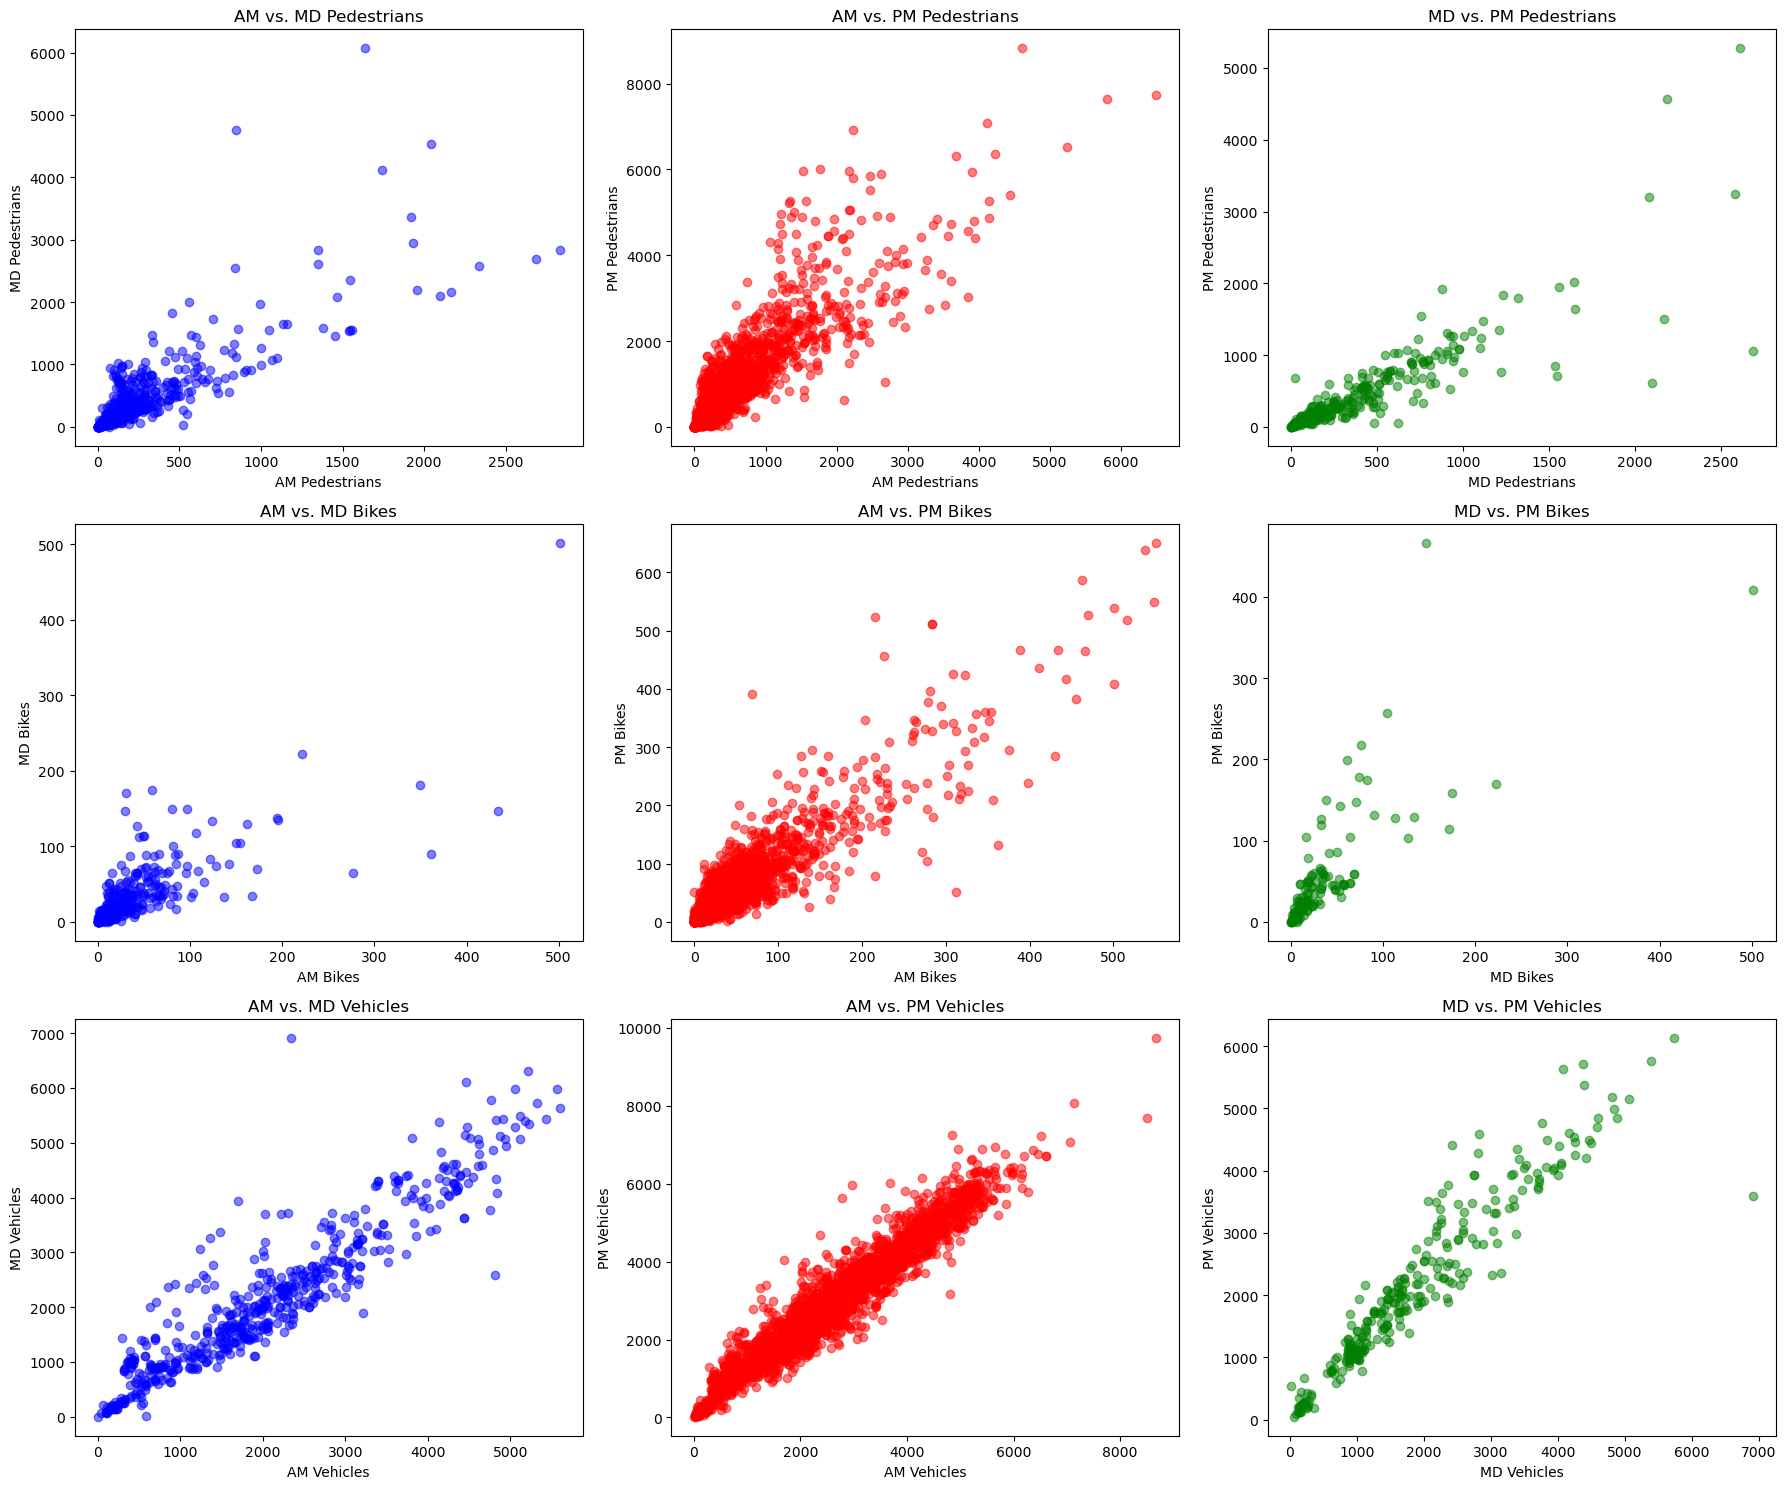

In [49]:
fig, axs = plt.subplots(3, 3, figsize=(18, 15))

# Setting up pedestrian plots
axs[0, 0].scatter(tmc_viz['AM_peds'], tmc_viz['MD_peds'], color='blue', alpha=0.5)
axs[0, 0].set_xlabel('AM Pedestrians')
axs[0, 0].set_ylabel('MD Pedestrians')
axs[0, 0].set_title('AM vs. MD Pedestrians')

axs[0, 1].scatter(tmc_viz['AM_peds'], tmc_viz['PM_peds'], color='red', alpha=0.5)
axs[0, 1].set_xlabel('AM Pedestrians')
axs[0, 1].set_ylabel('PM Pedestrians')
axs[0, 1].set_title('AM vs. PM Pedestrians')

axs[0, 2].scatter(tmc_viz['MD_peds'], tmc_viz['PM_peds'], color='green', alpha=0.5)
axs[0, 2].set_xlabel('MD Pedestrians')
axs[0, 2].set_ylabel('PM Pedestrians')
axs[0, 2].set_title('MD vs. PM Pedestrians')

# Setting up bike plots
axs[1, 0].scatter(tmc_viz['AM_bikes'], tmc_viz['MD_bikes'], color='blue', alpha=0.5)
axs[1, 0].set_xlabel('AM Bikes')
axs[1, 0].set_ylabel('MD Bikes')
axs[1, 0].set_title('AM vs. MD Bikes')

axs[1, 1].scatter(tmc_viz['AM_bikes'], tmc_viz['PM_bikes'], color='red', alpha=0.5)
axs[1, 1].set_xlabel('AM Bikes')
axs[1, 1].set_ylabel('PM Bikes')
axs[1, 1].set_title('AM vs. PM Bikes')

axs[1, 2].scatter(tmc_viz['MD_bikes'], tmc_viz['PM_bikes'], color='green', alpha=0.5)
axs[1, 2].set_xlabel('MD Bikes')
axs[1, 2].set_ylabel('PM Bikes')
axs[1, 2].set_title('MD vs. PM Bikes')

# Setting up vehicle plots
axs[2, 0].scatter(tmc_viz['AM_veh'], tmc_viz['MD_veh'], color='blue', alpha=0.5)
axs[2, 0].set_xlabel('AM Vehicles')
axs[2, 0].set_ylabel('MD Vehicles')
axs[2, 0].set_title('AM vs. MD Vehicles')

axs[2, 1].scatter(tmc_viz['AM_veh'], tmc_viz['PM_veh'], color='red', alpha=0.5)
axs[2, 1].set_xlabel('AM Vehicles')
axs[2, 1].set_ylabel('PM Vehicles')
axs[2, 1].set_title('AM vs. PM Vehicles')

axs[2, 2].scatter(tmc_viz['MD_veh'], tmc_viz['PM_veh'], color='green', alpha=0.5)
axs[2, 2].set_xlabel('MD Vehicles')
axs[2, 2].set_ylabel('PM Vehicles')
axs[2, 2].set_title('MD vs. PM Vehicles')

plt.tight_layout()
plt.show()

As the final step in this kernel, we aim to map the intersection count periods that were collected in 2019 or later and resulted in a vehicle volume within the bottom 20% of counts, along with pedestrian and bike volumes in the top 80% of counts.

These intersections could be prioritized for a no-vehicle, pedestrian-and-bike-only alteration (quite ambitious eh!).

In [9]:
# Example criteria: Bottom 20% for vehicles, Top 80% for pedestrians and bikes
vehicle_quantile = 0.2
ped_bike_quantile = 0.8
cut_off_date = pd.to_datetime('2019-01-01')

am_filter = (tmc_viz['AM_veh'] < tmc_viz['AM_veh'].quantile(vehicle_quantile)) & \
            (tmc_viz['AM_peds'] > tmc_viz['AM_peds'].quantile(ped_bike_quantile)) & \
            (tmc_viz['AM_bikes'] > tmc_viz['AM_bikes'].quantile(ped_bike_quantile)) & \
            (pd.to_datetime(tmc_viz['date']) >= cut_off_date)

md_filter = (tmc_viz['MD_veh'] < tmc_viz['MD_veh'].quantile(vehicle_quantile)) & \
            (tmc_viz['MD_peds'] > tmc_viz['MD_peds'].quantile(ped_bike_quantile)) & \
            (tmc_viz['MD_bikes'] > tmc_viz['MD_bikes'].quantile(ped_bike_quantile)) & \
            (pd.to_datetime(tmc_viz['date']) >= cut_off_date)
pm_filter = (tmc_viz['PM_veh'] < tmc_viz['PM_veh'].quantile(vehicle_quantile)) & \
            (tmc_viz['PM_peds'] > tmc_viz['PM_peds'].quantile(ped_bike_quantile)) & \
            (tmc_viz['PM_bikes'] > tmc_viz['PM_bikes'].quantile(ped_bike_quantile)) & \
            (pd.to_datetime(tmc_viz['date']) >= cut_off_date)
            
am_subset = tmc_viz[am_filter]
md_subset = tmc_viz[md_filter]
pm_subset = tmc_viz[pm_filter]

In [10]:
map_center = [tmc_viz['latitude'].mean(), tmc_viz['longitude'].mean()]
folium_map = folium.Map(location=map_center, zoom_start=13)

def add_markers(dataframe, period, marker_color):
    for _, row in dataframe.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"{period}: Vehicles={row[period+'_veh']}, Pedestrians={row[period+'_peds']}, Bikes={row[period+'_bikes']}, Date={row['date']}, Intersection={row['intersection']}",
            icon=folium.Icon(color=marker_color),
        ).add_to(folium_map)

add_markers(am_subset, 'AM', 'blue')
add_markers(md_subset, 'MD', 'green')
add_markers(pm_subset, 'PM', 'red')

legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: 130px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp; <b>Legend</b> <br>
      &nbsp; AM Period &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br>
      &nbsp; MD Period &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
      &nbsp; PM Period &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>
</div>
'''
legend = folium.Element(legend_html)
folium_map.get_root().html.add_child(legend)

folium_map